# Multi-Layer Quasi-Geostrophic Equations

In [1]:
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
from loguru import logger

%matplotlib inline

In [2]:
def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 3))

    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i].cpu().numpy(), cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    logger.debug(
        f"{name}: {quantity.shape} | {quantity.min():.6e} | {quantity.mean():.6e} | {quantity.median():.6e} | {quantity.max():.6e}"
    )

In [3]:
params = {
    # 'nx': 769, # HR
    # 'ny': 961, # HR
    "nx": 97,  # LR
    "ny": 121,  # LR
    "Lx": 3840.0e3,  # Length in the x direction (m)
    "Ly": 4800.0e3,  # Length in the y direction (m)
    "nl": 3,  # number of layers
    "heights": [350.0, 750.0, 2900.0],  # heights between layers (m)
    "reduced_gravities": [0.025, 0.0125],  # reduced gravity numbers (m/s^2)
    "f0": 9.375e-5,  # coriolis (s^-1)
    "a_2": 0.0,  # laplacian diffusion coef (m^2/s)
    # 'a_4': 2.0e9, # HR
    "a_4": 5.0e11,  # LR
    "beta": 1.754e-11,  # coriolis gradient (m^-1 s^-1)
    "delta_ek": 2.0,  # eckman height (m)
    # 'dt': 600., # HR
    "dt": 1200.0,  # LR
    "bcco": 0.2,  # boundary condition coef. (non-dim.)
    "tau0": 2.0e-5,  # wind stress magnitude m/s^2
    "n_ens": 0,  # 0 for no ensemble,
    "device": "cpu",  # torch only, 'cuda' or 'cpu'
    "p_prime": "",
}

In [4]:
4800.0e3 / 2.0

2400000.0

In [5]:
import typing as tp


class PDEParams(tp.NamedTuple):
    f0: float = 9.375e-5  # coriolis (s^-1)
    beta: float = 1.754e-11  # coriolis gradient (m^-1 s^-1)
    tau0: float = 2.0e-5  # wind stress magnitude m/s^2
    y0: float = 2400000.0  # m
    a_2: float = 0.0  # laplacian diffusion coef (m^2/s)
    a_4: float = 5.0e11  # LR # 2.0e9 # HR
    bcco: float = 0.2  # boundary condition coef. (non-dim.)
    delta_ek: float = 2.0  # eckman height (m)

    @property
    def zfbc(self):
        return self.bcco / (1.0 + 0.5 * self.bcco)


pde_params = PDEParams()

In [6]:
import typing as tp

In [7]:
import functools as ft
from dataclasses import dataclass


@dataclass
class Domain:
    nx: int
    ny: int
    Lx: int
    Ly: int
    dx: float
    dy: float
    x: torch.FloatTensor
    y: torch.FloatTensor

    def __init__(self, nx, ny, Lx, Ly):
        self.Lx = Lx
        self.Ly = Ly
        self.nx = nx
        self.ny = ny
        self.dx = Lx / (nx - 1)
        self.dy = Ly / (ny - 1)

        X = torch.linspace(0, Lx, nx)
        Y = torch.linspace(0, Ly, ny)
        self.x, self.y = torch.meshgrid(X, Y, indexing="ij")

In [8]:
domain = Domain(nx=params["nx"], ny=params["ny"], Lx=params["Lx"], Ly=params["Ly"])
domain.dx

40000.0

## Compute A Matrix

In [9]:
class HeightParams(tp.NamedTuple):
    heights: tp.List[float]
    reduced_gravities: tp.List[float]
    num_layers: int

In [10]:
height_params = HeightParams(
    heights=params["heights"],
    reduced_gravities=params["reduced_gravities"],
    num_layers=params["nl"],
)

# num_layers = params["nl"]
# reduced_gravities = params["reduced_gravities"]
# heights = params["heights"]

In [11]:
def calculate_A_matrix(params: HeightParams):
    assert len(params.heights) - 1 == len(params.reduced_gravities)
    A = torch.zeros((params.num_layers, params.num_layers))
    A[0, 0] = 1.0 / (params.heights[0] * params.reduced_gravities[0])
    A[0, 1] = -1.0 / (params.heights[0] * params.reduced_gravities[0])
    for i in range(1, params.num_layers - 1):
        A[i, i - 1] = -1.0 / (params.heights[i] * params.reduced_gravities[i - 1])
        A[i, i] = (
            1.0
            / params.heights[i]
            * (1 / params.reduced_gravities[i] + 1 / params.reduced_gravities[i - 1])
        )
        A[i, i + 1] = -1.0 / (params.heights[i] * params.reduced_gravities[i])
    A[-1, -1] = 1.0 / (
        params.heights[params.num_layers - 1]
        * params.reduced_gravities[params.num_layers - 2]
    )
    A[-1, -2] = -1.0 / (
        params.heights[params.num_layers - 1]
        * params.reduced_gravities[params.num_layers - 2]
    )
    return A.type(torch.float64)

In [12]:
height_params

HeightParams(heights=[350.0, 750.0, 2900.0], reduced_gravities=[0.025, 0.0125], num_layers=3)

In [13]:
A = calculate_A_matrix(height_params)
A

tensor([[ 0.1143, -0.1143,  0.0000],
        [-0.0533,  0.1600, -0.1067],
        [ 0.0000, -0.0276,  0.0276]], dtype=torch.float64)

### Calculate Layer To Mode Matrices

In [14]:
def compute_layer_to_mode_matrices(A):
    lambd_r, R = torch.linalg.eig(A)
    _, L = torch.linalg.eig(A.T)
    lambd = lambd_r.real
    R, L = R.real, L.real
    Cl2m = torch.diag(1.0 / torch.diag(L.T @ R)) @ L.T

    return lambd, Cl2m, R

In [15]:
@dataclass
class AMatrices:
    A: torch.Tensor
    lambd: torch.Tensor
    Cl2m: torch.Tensor
    Cm2l: torch.Tensor

    def __init__(self, A):
        self.A = A
        self.lambd, self.Cl2m, self.Cm2l = compute_layer_to_mode_matrices(A)

In [16]:
A_matrices = AMatrices(A=A)
A_matrices.Cl2m, A_matrices.Cm2l

(tensor([[-0.4319,  0.9224, -0.4905],
         [-0.6580, -0.5009,  1.1589],
         [ 0.1516,  0.3248,  1.2557]], dtype=torch.float64),
 tensor([[-0.7050, -0.9240,  0.5774],
         [ 0.7026, -0.3282,  0.5774],
         [-0.0966,  0.1964,  0.5774]], dtype=torch.float64))

### HelmHoltz Matrices

In [17]:
## functions to solve elliptic equation with homogeneous boundary conditions
def compute_laplace_dst(nx, ny, dx, dy, **kwargs):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator."""
    x, y = torch.meshgrid(
        torch.arange(1, nx - 1, **kwargs),
        torch.arange(1, ny - 1, **kwargs),
        indexing="ij",
    )
    return (
        2 * (torch.cos(torch.pi / (nx - 1) * x) - 1) / dx**2
        + 2 * (torch.cos(torch.pi / (ny - 1) * y) - 1) / dy**2
    )

In [18]:
lap_dst = (
    compute_laplace_dst(domain.nx, domain.ny, domain.dx, domain.dy) / params["f0"] ** 2
)
print_debug_quantity(lap_dst)

helmoltz_dst = lap_dst.reshape(
    (1, domain.nx - 2, domain.ny - 2)
) - A_matrices.lambd.reshape((height_params.num_layers, 1, 1))
print_debug_quantity(helmoltz_dst[0])
print_debug_quantity(helmoltz_dst[1])
print_debug_quantity(helmoltz_dst[2])

2023-07-11 18:19:18.914 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([95, 119]) | -5.687640e-01 | -2.844445e-01 | -2.844444e-01 | -1.248847e-04
2023-07-11 18:19:18.918 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([95, 119]) | -7.969477e-01 | -5.126281e-01 | -5.126281e-01 | -2.283086e-01
2023-07-11 18:19:18.920 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([95, 119]) | -6.424522e-01 | -3.581327e-01 | -3.581326e-01 | -7.381310e-02
2023-07-11 18:19:18.921 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([95, 119]) | -5.687640e-01 | -2.844444e-01 | -2.844444e-01 | -1.248833e-04


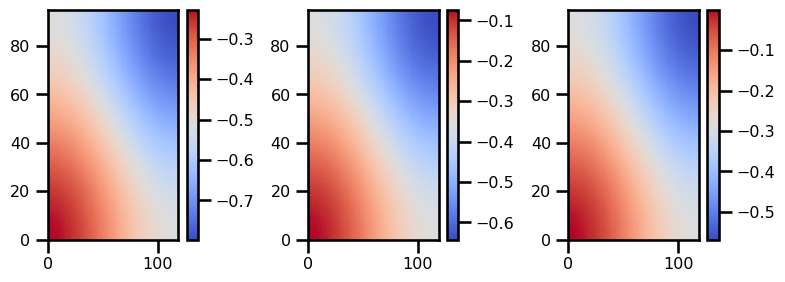

In [19]:
plot_field(helmoltz_dst)

### Inversion Scheme

In [20]:
def dstI1D(x, norm="ortho"):
    """1D type-I discrete sine transform."""
    return torch.fft.irfft(-1j * F.pad(x, (1, 1)), dim=-1, norm=norm)[
        ..., 1 : x.shape[-1] + 1
    ]


def dstI2D(x, norm="ortho"):
    """2D type-I discrete sine transform."""
    return dstI1D(dstI1D(x, norm=norm).transpose(-1, -2), norm=norm).transpose(-1, -2)


def inverse_elliptic_dst(f, operator_dst):
    """Inverse elliptic operator (e.g. Laplace, Helmoltz)
    using float32 discrete sine transform."""
    # return dstI2D((dstI2D(f.type(torch.float32)) / operator_dst).type(torch.float64))
    return dstI2D(dstI2D(f.type(torch.float32)) / operator_dst).type(torch.float64)

In [21]:
def calculate_homogeneous_sol(domain, helmoltz_dst, lambd):
    nl = helmoltz_dst.shape[0]

    # calculate constant field
    constant_field = torch.ones((nl, domain.nx, domain.ny)) / (domain.nx * domain.ny)
    print_debug_quantity(constant_field)

    # get solutions to inversion
    s_solutions = torch.zeros_like(constant_field)
    s_solutions[:, 1:-1, 1:-1] = inverse_elliptic_dst(
        constant_field[:, 1:-1, 1:-1], helmoltz_dst
    )
    print_debug_quantity(s_solutions[0])
    print_debug_quantity(s_solutions[1])
    print_debug_quantity(s_solutions[2])

    # ignore last solution correponding to lambd = 0, i.e. Laplace equation
    homogeneous_sol = (
        constant_field + s_solutions * lambd.reshape((params["nl"], 1, 1))
    )[:-1]

    return homogeneous_sol


homogeneous_sol = calculate_homogeneous_sol(
    domain, helmoltz_dst, lambd=A_matrices.lambd
)

print_debug_quantity(homogeneous_sol)

2023-07-11 18:19:24.262 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([3, 97, 121]) | 8.520065e-05 | 8.520065e-05 | 8.520065e-05 | 8.520065e-05
2023-07-11 18:19:24.275 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([97, 121]) | -3.733863e-04 | -3.562605e-04 | -3.733862e-04 | 0.000000e+00
2023-07-11 18:19:24.276 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([97, 121]) | -1.156232e-03 | -1.088502e-03 | -1.156231e-03 | 0.000000e+00
2023-07-11 18:19:24.277 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([97, 121]) | -9.883048e-01 | -4.651709e-01 | -4.557938e-01 | 0.000000e+00
2023-07-11 18:19:24.282 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([2, 97, 121]) | -1.704109e-11 | 4.449327e-06 | 1.451378e-11 | 8.520065e-05


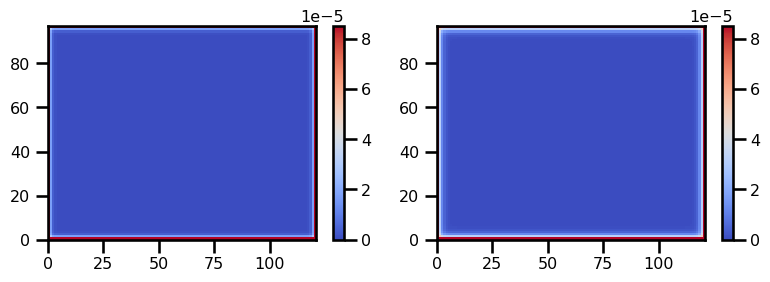

In [22]:
plot_field(homogeneous_sol)

### Alpha Matrices

In [23]:
def compute_alpha_matrices(Cm2l, homogeneous_sol):
    num_layers = len(Cm2l)
    print_debug_quantity(Cm2l)
    print_debug_quantity(homogeneous_sol)
    M = (Cm2l[1:] - Cm2l[:-1])[
        : num_layers - 1, : num_layers - 1
    ] * homogeneous_sol.mean((1, 2)).reshape((1, num_layers - 1))
    print_debug_quantity(M)
    M_inv = torch.linalg.inv(M)
    print_debug_quantity(M_inv)
    return -M_inv @ (Cm2l[1:, :-1] - Cm2l[:-1, :-1])


alpha_matrix = compute_alpha_matrices(A_matrices.Cm2l, homogeneous_sol)
print_debug_quantity(alpha_matrix)

2023-07-11 18:19:26.060 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([3, 3]) | -9.239602e-01 | 6.413960e-02 | 1.963961e-01 | 7.026015e-01
2023-07-11 18:19:26.062 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([2, 97, 121]) | -1.704109e-11 | 4.449327e-06 | 1.451378e-11 | 8.520065e-05
2023-07-11 18:19:26.065 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([2, 2]) | -3.123218e-06 | 1.992230e-06 | 2.618256e-06 | 5.500621e-06
2023-07-11 18:19:26.079 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([2, 2]) | -1.255166e+05 | 8.726757e+04 | 1.105301e+05 | 2.322096e+05
2023-07-11 18:19:26.082 | DEBUG    | __main__:print_debug_quantity:14 - : torch.Size([2, 2]) | -2.558974e+05 | -1.140661e+05 | -2.003672e+05 | 1.455192e-11


## Forcing

$$
F(x,y) = - \tau \cos(\frac{2\pi y}{L})
$$

In [24]:
# initialize the Forcing term
tau = torch.zeros((domain.nx, domain.ny, 2)).type(torch.float64)

# create staggered coordinates
y_coords = torch.arange(domain.ny) + 0.5
tau[:, :, 0] = -pde_params.tau0 * torch.cos(2 * torch.pi * (y_coords / domain.ny))
print_debug_quantity(tau, "Tau")

2023-07-11 18:19:27.276 | DEBUG    | __main__:print_debug_quantity:14 - Tau: torch.Size([97, 121, 2]) | -1.999326e-05 | -1.666546e-13 | 0.000000e+00 | 2.000000e-05


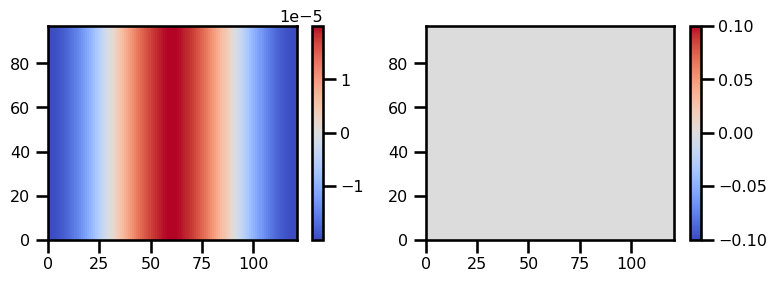

In [25]:
plot_field(tau.transpose(2, 0).transpose(1, 2))

In [26]:
def curl_wind(tau, dx, dy):
    tau_x = 0.5 * (tau[:-1, :, 0] + tau[1:, :, 0])
    print_debug_quantity(tau_x, "tau_x")
    tau_y = 0.5 * (tau[:, :-1, 1] + tau[:, 1:, 1])
    print_debug_quantity(tau_y, "tau_y")
    dF2dX = (tau_y[1:] - tau_y[:-1]) / dx
    print_debug_quantity(dF2dX, "dF2dX")
    dF1dY = (tau_x[:, 1:] - tau_x[:, :-1]) / dy
    print_debug_quantity(dF1dY, "dF1dY")
    return dF2dX - dF1dY


def center_average_2D(u):
    return 0.25 * (u[:-1, :-1] + u[:-1, 1:] + u[1:, :-1] + u[1:, 1:])

In [27]:
curl_stagg = curl_wind(tau, domain.dx, domain.dy)
print_debug_quantity(curl_stagg, "Wind curl_stagg")
wind_forcing = center_average_2D(curl_stagg) / (
    pde_params.f0 * height_params.heights[0]
)
print_debug_quantity(wind_forcing, "Wind Forcing")

2023-07-11 18:19:28.445 | DEBUG    | __main__:print_debug_quantity:14 - tau_x: torch.Size([96, 121]) | -1.999326e-05 | -3.333091e-13 | 2.596290e-07 | 2.000000e-05
2023-07-11 18:19:28.447 | DEBUG    | __main__:print_debug_quantity:14 - tau_y: torch.Size([97, 120]) | 0.000000e+00 | 0.000000e+00 | 0.000000e+00 | 0.000000e+00
2023-07-11 18:19:28.449 | DEBUG    | __main__:print_debug_quantity:14 - dF2dX: torch.Size([96, 120]) | 0.000000e+00 | 0.000000e+00 | 0.000000e+00 | 0.000000e+00
2023-07-11 18:19:28.452 | DEBUG    | __main__:print_debug_quantity:14 - dF1dY: torch.Size([96, 120]) | -2.595868e-11 | -3.789561e-19 | -6.739356e-13 | 2.595844e-11
2023-07-11 18:19:28.458 | DEBUG    | __main__:print_debug_quantity:14 - Wind curl_stagg: torch.Size([96, 120]) | -2.595844e-11 | 3.789561e-19 | -6.739356e-13 | 2.595868e-11
2023-07-11 18:19:28.463 | DEBUG    | __main__:print_debug_quantity:14 - Wind Forcing: torch.Size([95, 119]) | -7.908486e-10 | 1.164619e-17 | 0.000000e+00 | 7.908477e-10


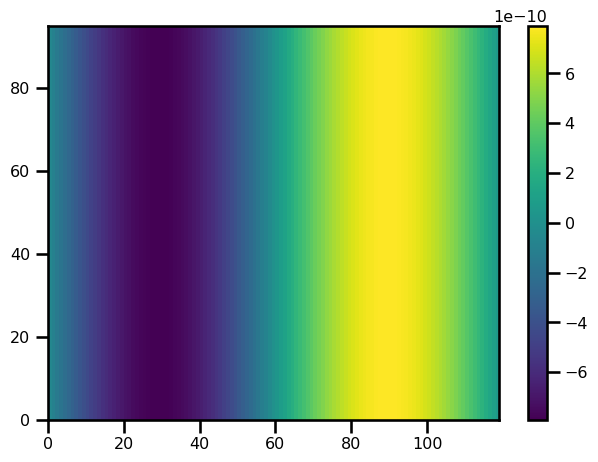

In [28]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(wind_forcing)
plt.colorbar(pts)

plt.tight_layout()
plt.show()

## Initialize State

### Pressure

In [34]:
p_shape = (height_params.num_layers, domain.nx, domain.ny)
p_shape_flat = p_shape[:-2] + (domain.nx * domain.ny,)
# p = torch.zeros(p_shape).type(torch.float64)
p = torch.from_numpy(np.load("./p_380yrs_HRDS.npy", allow_pickle=True)).type(
    torch.float64
)
p_modes = torch.zeros_like(p).type(torch.float64)

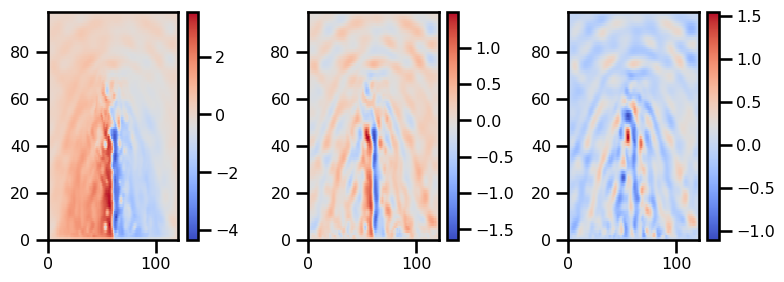

In [35]:
plot_field(p)

### Vorticity

In [41]:
def laplacian_h_boundaries(f, fc):
    return fc * (
        torch.cat([f[..., 1, 1:-1], f[..., -2, 1:-1], f[..., 1], f[..., -2]], dim=-1)
        - torch.cat([f[..., 0, 1:-1], f[..., -1, 1:-1], f[..., 0], f[..., -1]], dim=-1)
    )


def laplacian_h_nobc(f):
    return (
        f[..., 2:, 1:-1]
        + f[..., :-2, 1:-1]
        + f[..., 1:-1, 2:]
        + f[..., 1:-1, :-2]
        - 4 * f[..., 1:-1, 1:-1]
    )


def laplacian_h(f, fc):
    delta_f = torch.zeros_like(f)

    # Laplacian w/o BCs
    out = laplacian_h_nobc(f)
    # print_debug_quantity(out, "NABLA F (INTERIOR)")
    delta_f[..., 1:-1, 1:-1] = out
    # print_debug_quantity(delta_f, "NABLA F (FULL | No Bnds)")

    # Laplacian w/ BCs
    delta_f_bound = laplacian_h_boundaries(f, fc)
    # print_debug_quantity(delta_f_bound, "NABLA F (Bnds)")
    nx, ny = f.shape[-2:]

    delta_f[..., 0, 1:-1] = delta_f_bound[..., : ny - 2]
    delta_f[..., -1, 1:-1] = delta_f_bound[..., ny - 2 : 2 * ny - 4]
    delta_f[..., 0] = delta_f_bound[..., 2 * ny - 4 : nx + 2 * ny - 4]
    delta_f[..., -1] = delta_f_bound[..., nx + 2 * ny - 4 : 2 * nx + 2 * ny - 4]
    # print_debug_quantity(delta_f_bound, "NABLA F (FULL)")
    return delta_f


def pressure_to_vorticity(p, A, pde_params):
    # matrix multiply the nodes
    Ap = -torch.einsum("ij,jkl->ikl", A, p)
    # print_debug_quantity(Ap, "Ap")

    # print(Ap.min(), Ap.max())

    # calculate beta term
    beta_term = (pde_params.beta / pde_params.f0) * (domain.y - pde_params.y0)
    # print_debug_quantity(beta_term, "Beta Term")

    # calculate Laplacian
    lap_term = laplacian_h(p, pde_params.zfbc) / (pde_params.f0 * domain.dx) ** 2
    # print_debug_quantity(lap_term, "Lap Term")

    # calculate vorticity
    q = lap_term + Ap + beta_term
    return q

In [42]:
print_debug_quantity(p, "PRESSURE")
q = pressure_to_vorticity(p, A_matrices.A, pde_params)
print_debug_quantity(q, "VORTICITY")

2023-07-11 18:49:40.638 | DEBUG    | __main__:print_debug_quantity:14 - PRESSURE: torch.Size([3, 97, 121]) | -4.332182e+00 | 3.335592e-02 | 3.041292e-02 | 3.561408e+00
2023-07-11 18:49:40.642 | DEBUG    | __main__:print_debug_quantity:14 - VORTICITY: torch.Size([3, 97, 121]) | -4.657202e-01 | -6.788327e-06 | -2.769970e-03 | 4.963626e-01


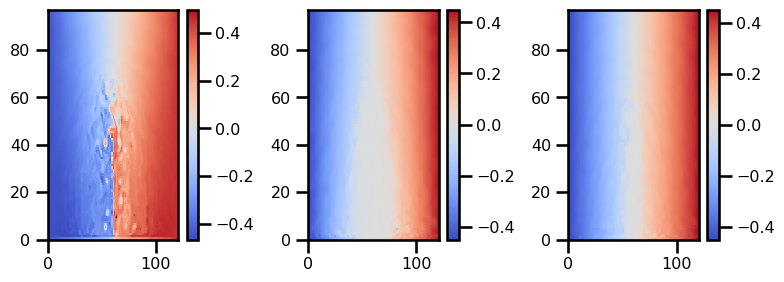

In [38]:
plot_field(q)

In [ ]:
# def pressure_to_vorticity(p, A, pde_params):
#     logger.debug(f"Pressure --> Vorticity")
#     logger.debug("PRESSURE")
#     print_debug_quantity(p)
#     logger.debug("A")
#     print_debug_quantity(A)
#     # matrix multiply the nodes
#     Ap = - torch.einsum("ij,jkl->ikl", A, p)
#     logger.debug(f"Ap, {Ap.shape}")
#     print_debug_quantity(-Ap)

#     # print(Ap.min(), Ap.max())

#     # calculate beta term
#     beta_term = (pde_params.beta / pde_params.f0) * (domain.y - pde_params.y0)
#     logger.debug(f"Beta, {beta_term.shape}")
#     print_debug_quantity(beta_term)

#     # calculate Laplacian
#     logger.debug("PRESSURE")
#     print_debug_quantity(p)
#     logger.debug(f"zfbc: {pde_params.zfbc} | f0: {pde_params.f0} | nx")
#     lap_term = laplacian_h(p, pde_params.zfbc) / (pde_params.f0 * domain.dx)**2
#     logger.debug(f"Lap, {lap_term.shape}")
#     print_debug_quantity(lap_term)

#     # calculate vorticity
#     q = lap_term + Ap + beta_term
#     return q


def pressure_to_vorticity(p, A, pde_params):
    # matrix multiply the nodes
    Ap = -torch.einsum("ij,jkl->ikl", A, p)

    # print(Ap.min(), Ap.max())

    # calculate beta term
    beta_term = (pde_params.beta / pde_params.f0) * (domain.y - pde_params.y0)

    # calculate Laplacian
    lap_term = laplacian_h(p, pde_params.zfbc) / (pde_params.f0 * domain.dx) ** 2

    # calculate vorticity
    q = lap_term + Ap + beta_term
    return q

### Compute Velocities

We are going to compute them on a staggered grid.

$$
\begin{aligned}
u &= -\partial_y\psi \\
v &= \partial_y\psi
\end{aligned}
$$

In [43]:
def grad_perp(f):
    """Orthogonal gradient computed ...,on staggered grid."""
    return f[..., :-1] - f[..., 1:], f[..., 1:, :] - f[..., :-1, :]


def compute_velocities(p):
    return grad_perp(p / (pde_params.f0 * domain.dx))

### Compute Determinant Jacobian Term

In [44]:
## discrete spatial differential operators
def jacobi_h(f, g):
    """Arakawa discretisation of Jacobian J(f,g).
    Scalar fields f and g must have the same dimension.
    Grid is regular and dx = dy."""
    dx_f = f[..., 2:, :] - f[..., :-2, :]
    dx_g = g[..., 2:, :] - g[..., :-2, :]
    dy_f = f[..., 2:] - f[..., :-2]
    dy_g = g[..., 2:] - g[..., :-2]
    return (
        (dx_f[..., 1:-1] * dy_g[..., 1:-1, :] - dx_g[..., 1:-1] * dy_f[..., 1:-1, :])
        + (
            (
                f[..., 2:, 1:-1] * dy_g[..., 2:, :]
                - f[..., :-2, 1:-1] * dy_g[..., :-2, :]
            )
            - (f[..., 1:-1, 2:] * dx_g[..., 2:] - f[..., 1:-1, :-2] * dx_g[..., :-2])
        )
        + (
            (g[..., 1:-1, 2:] * dx_f[..., 2:] - g[..., 1:-1, :-2] * dx_f[..., :-2])
            - (
                g[..., 2:, 1:-1] * dy_f[..., 2:, :]
                - g[..., :-2, 1:-1] * dy_f[..., :-2, :]
            )
        )
    ) / 12.0

In [47]:
rhs = 1.0 / (pde_params.f0 * domain.dx * domain.dy) * jacobi_h(q, p)
print_debug_quantity(rhs, "RHS DET JACOBIAN")

2023-07-11 18:52:38.128 | DEBUG    | __main__:print_debug_quantity:14 - RHS DET JACOBIAN: torch.Size([3, 95, 119]) | -1.564097e-06 | -1.405443e-12 | -1.383592e-11 | 1.195297e-06


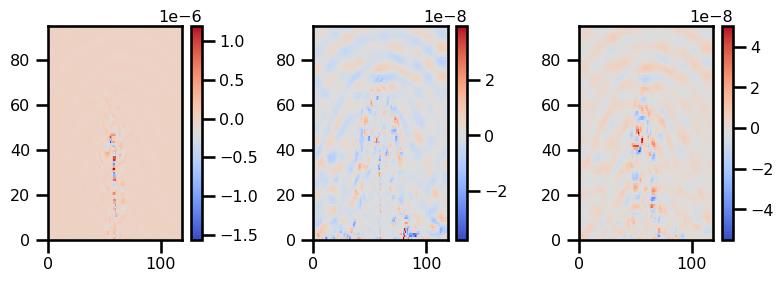

In [46]:
plot_field(rhs)

In [51]:
def diffusion_term(p, pde_params, domain):
    return pde_params.a_2 / pde_params.f0**2 / domain.dx**4 * laplacian_h_nobc(p)


def hyperdiffusion_term(p, pde_params, domain):
    return (
        -(pde_params.a_4 / pde_params.f0**2)
        / domain.dx**6
        * laplacian_h_nobc(laplacian_h(p, pde_params.zfbc))
    )


def bottom_friction(p, pde_params, domain, height_params):
    return (
        pde_params.delta_ek
        / (2 * np.abs(pde_params.f0) * domain.dx**2 * (-height_params.heights[-1]))
        * laplacian_h_nobc(p[..., -1:, :, :])
    )

In [52]:
p_diff = p

# calculate
delta2_p = laplacian_h(p_diff, pde_params.zfbc)
print_debug_quantity(delta2_p, "Laplacian Term")
if pde_params.a_2 != 0.0:
    diff_term = diffusion_term(delta2_p, pde_params, domain)
    print_debug_quantity(diff_term, "Diffusion Term")
    rhs += diff_term
if pde_params.a_4 != 0.0:
    hyperdiff_term = hyperdiffusion_term(delta2_p, pde_params, domain)
    print_debug_quantity(hyperdiff_term, "Diffusion Term")
    rhs += hyperdiff_term

rhs[..., 0:1, :, :] += wind_forcing
bottom_term = bottom_friction(p, pde_params, domain, height_params)
print_debug_quantity(bottom_term, "Bottom Friction")
rhs[..., -1:, :, :] += bottom_term

2023-07-11 18:55:04.114 | DEBUG    | __main__:print_debug_quantity:14 - Laplacian Term: torch.Size([3, 97, 121]) | -2.852461e+00 | -9.280515e-05 | 7.083754e-04 | 3.835035e+00
2023-07-11 18:55:04.119 | DEBUG    | __main__:print_debug_quantity:14 - Diffusion Term: torch.Size([3, 95, 119]) | -7.209133e-07 | -4.914557e-12 | 8.343140e-13 | 6.775439e-07
2023-07-11 18:55:04.122 | DEBUG    | __main__:print_debug_quantity:14 - Bottom Friction: torch.Size([1, 95, 119]) | -1.221567e-09 | 4.609835e-13 | -2.387789e-12 | 1.503295e-09


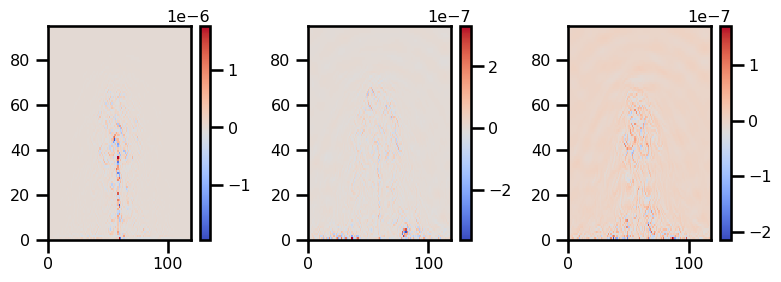

In [54]:
plot_field(rhs)

In [55]:
def advection_rhs(q, p):
    rhs = 1.0 / (pde_params.f0 * domain.dx * domain.dy) * jacobi_h(q, p)

    # calculate
    delta2_p = laplacian_h(p, pde_params.zfbc)
    if pde_params.a_2 != 0.0:
        rhs += diffusion_term(delta2_p, pde_params, domain)
    if pde_params.a_4 != 0.0:
        rhs += hyperdiffusion_term(delta2_p, pde_params, domain)

    rhs[..., 0:1, :, :] += wind_forcing
    rhs[..., -1:, :, :] += bottom_friction(p, pde_params, domain, height_params)

    return rhs

In [56]:
# %timeit rhs = advection_rhs(q, p)

In [59]:
advection_rhs_jitted = torch.jit.trace(advection_rhs, (q, p))
rhs = advection_rhs_jitted(q, p)
print_debug_quantity(rhs, "RHS")

2023-07-11 19:03:37.372 | DEBUG    | __main__:print_debug_quantity:14 - RHS: torch.Size([3, 95, 119]) | -1.502200e-06 | -6.166335e-12 | 1.789505e-12 | 1.339342e-06


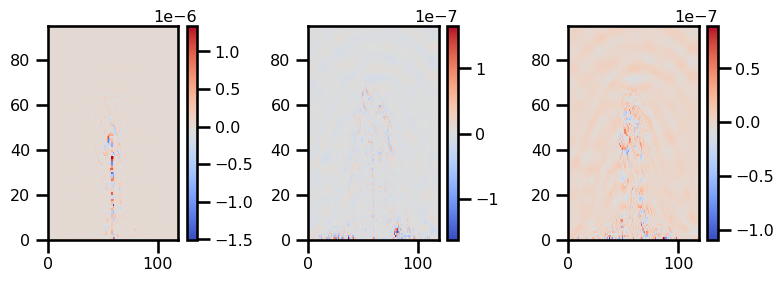

In [58]:
plot_field(rhs)

## Time Derivatives

In [60]:
# initialize terms
print_debug_quantity(p, "PRESSURE")
q = pressure_to_vorticity(p, A_matrices.A, pde_params)
print_debug_quantity(q, "VORTICITY")

# advect vorticity inside of the domain
# print(f"Vorticity: {q.shape}")
# print(f"Pressure: {p.shape}")
dq_over_f0 = F.pad(advection_rhs(q, p), (1, 1, 1, 1))

# print(f"RHS Vorticity: {dq_over_f0.shape}")

# solve helmholtz eq for pressure
rhs_helmholtz = torch.einsum("ij,jkl->ikl", A_matrices.Cl2m, dq_over_f0)
dp_modes = F.pad(
    inverse_elliptic_dst(rhs_helmholtz[..., 1:-1, 1:-1], helmoltz_dst), (1, 1, 1, 1)
)
# print(f"dp (Modes): {dp_modes.shape}")

# ensure mass convervation
dalpha = (
    alpha_matrix @ dp_modes[..., :-1, :, :].mean((-2, -1)).unsqueeze(-1)
).unsqueeze(-1)
# print(f"dalpha: {dalpha.shape}")

dp_modes[..., :-1, :, :] += dalpha * homogeneous_sol
# print(f"dp (Modes): {dp_modes.shape}")

dp = torch.einsum("ij,jkl->ikl", A_matrices.Cm2l, dp_modes)
# print(f"dp: {dp.shape}")

# update vorticity at the boundaries
dp_bound = torch.cat(
    [dp[..., 0, 1:-1], dp[..., -1, 1:-1], dp[..., :, 0], dp[..., :, -1]], dim=-1
)
# print(f"dp_bound: {dp_bound.shape}")
delta_p_bound = laplacian_h_boundaries(
    dp / (pde_params.f0 * domain.dx) ** 2, pde_params.zfbc
)
# print(f"delta_p_bound: {delta_p_bound.shape}")
dq_over_f0_bound = delta_p_bound - A_matrices.A @ dp_bound
# print(f"dq_over_f_bound: {dq_over_f0_bound.shape}")

dq_over_f0[..., 0, 1:-1] = dq_over_f0_bound[..., : domain.ny - 2]
dq_over_f0[..., -1, 1:-1] = dq_over_f0_bound[..., domain.ny - 2 : 2 * domain.ny - 4]
dq_over_f0[..., 0] = dq_over_f0_bound[
    ..., 2 * domain.ny - 4 : domain.nx + 2 * domain.ny - 4
]
dq_over_f0[..., -1] = dq_over_f0_bound[
    ..., domain.nx + 2 * domain.ny - 4 : 2 * domain.nx + 2 * domain.ny - 4
]

2023-07-11 19:12:18.096 | DEBUG    | __main__:print_debug_quantity:14 - PRESSURE: torch.Size([3, 97, 121]) | -4.332182e+00 | 3.335592e-02 | 3.041292e-02 | 3.561408e+00
2023-07-11 19:12:18.117 | DEBUG    | __main__:print_debug_quantity:14 - VORTICITY: torch.Size([3, 97, 121]) | -4.657202e-01 | -6.788327e-06 | -2.769970e-03 | 4.963626e-01


In [ ]:
plot_field(dp)

plot_field(dq_over_f0)

In [82]:
def time_derivative(q, p):
    # advect vorticity inside of the domain
    dq_over_f0 = advection_rhs(q, p)
    print_debug_quantity(dq_over_f0, "dq_f0")
    dq_over_f0 = F.pad(dq_over_f0, (1, 1, 1, 1))
    print_debug_quantity(dq_over_f0, "dq_f0")

    # solve helmholtz eq for pressure
    rhs_helmholtz = torch.einsum("ij,jkl->ikl", A_matrices.Cl2m, dq_over_f0)
    print_debug_quantity(rhs_helmholtz, "rhs_helmholtz")
    dp_modes = inverse_elliptic_dst(rhs_helmholtz[..., 1:-1, 1:-1], helmoltz_dst)
    dp_modes = F.pad(dp_modes, (1, 1, 1, 1))
    print_debug_quantity(dp_modes, "dp_modes")

    # ensure mass convervation
    dalpha = alpha_matrix @ dp_modes[..., :-1, :, :].mean((-2, -1))
    print_debug_quantity(dalpha, "dalpha")
    dalpha = dalpha.unsqueeze(-1).unsqueeze(-1)
    print_debug_quantity(dalpha, "dalpha")
    dp_modes[..., :-1, :, :] += dalpha * homogeneous_sol
    print_debug_quantity(dp_modes, "dp_modes")
    dp = torch.einsum("ij,jkl->ikl", A_matrices.Cm2l, dp_modes)
    print_debug_quantity(dp, "dp")

    # update vorticity at the boundaries
    delta_p_bound = laplacian_h_boundaries(
        dp / (pde_params.f0 * domain.dx) ** 2, pde_params.zfbc
    )
    print_debug_quantity(delta_p_bound, "delta_p_bound")

    dp_bound = torch.cat(
        [dp[..., 0, 1:-1], dp[..., -1, 1:-1], dp[..., :, 0], dp[..., :, -1]], dim=-1
    )
    print_debug_quantity(dp_bound, "dp_bound")
    dq_over_f0_bound = delta_p_bound - A_matrices.A @ dp_bound
    print_debug_quantity(dp_bound, "dp_bound")

    dq_over_f0[..., 0, 1:-1] = dq_over_f0_bound[..., : domain.ny - 2]
    dq_over_f0[..., -1, 1:-1] = dq_over_f0_bound[..., domain.ny - 2 : 2 * domain.ny - 4]
    dq_over_f0[..., 0] = dq_over_f0_bound[
        ..., 2 * domain.ny - 4 : domain.nx + 2 * domain.ny - 4
    ]
    dq_over_f0[..., -1] = dq_over_f0_bound[
        ..., domain.nx + 2 * domain.ny - 4 : 2 * domain.nx + 2 * domain.ny - 4
    ]

    return dq_over_f0, dp

In [84]:
# initialize terms
print_debug_quantity(p, "PRESSURE")
q = pressure_to_vorticity(p, A_matrices.A, pde_params)
print_debug_quantity(q, "VORTICITY")

dq, dp = time_derivative(q, p)
print_debug_quantity(dp, "dp")
print_debug_quantity(dq, "dq")

2023-07-11 19:48:15.601 | DEBUG    | __main__:print_debug_quantity:14 - PRESSURE: torch.Size([3, 97, 121]) | -4.332182e+00 | 3.335592e-02 | 3.041292e-02 | 3.561408e+00
2023-07-11 19:48:15.607 | DEBUG    | __main__:print_debug_quantity:14 - VORTICITY: torch.Size([3, 97, 121]) | -4.657202e-01 | -6.788327e-06 | -2.769970e-03 | 4.963626e-01
2023-07-11 19:48:15.611 | DEBUG    | __main__:print_debug_quantity:14 - dq_f0: torch.Size([3, 95, 119]) | -1.502200e-06 | -6.166335e-12 | 1.789505e-12 | 1.339342e-06
2023-07-11 19:48:15.612 | DEBUG    | __main__:print_debug_quantity:14 - dq_f0: torch.Size([3, 97, 121]) | -1.502200e-06 | -5.939373e-12 | 0.000000e+00 | 1.339342e-06
2023-07-11 19:48:15.614 | DEBUG    | __main__:print_debug_quantity:14 - rhs_helmholtz: torch.Size([3, 97, 121]) | -8.917591e-07 | -1.924375e-11 | 0.000000e+00 | 9.745410e-07
2023-07-11 19:48:15.619 | DEBUG    | __main__:print_debug_quantity:14 - dp_modes: torch.Size([3, 97, 121]) | -4.214962e-06 | 1.710896e-08 | 1.804562e-10 | 

In [ ]:
plot_field(dp)
plot_field(dq)

In [ ]:
def one_step(q, p, dt):
    # print(f"VORTICITY:", q.min(), q.max())
    q_ = torch.clone(q)
    logger.debug("Starting Time Step...")
    logger.debug(f"q_f0")
    print_debug_quantity(q)
    logger.debug(f"p")
    print_debug_quantity(p)
    logger.debug("Computing RHS...")
    dq, dp = time_derivative(q_, p)
    logger.debug(f"dq_f0")
    print_debug_quantity(dq)
    logger.debug(f"dp")
    print_debug_quantity(dp)
    # plot_field(dp)
    # plot_field(dq)
    # print(f"DERVORTICITY:", dq.min(), dq.max())
    # print(f"VORTICITY:", q.min(), q.max())

    # Euler Step
    logger.debug("Euler Step...")
    dq_0, dp_0 = torch.clone(dq), torch.clone(dp)
    q += dt * dq_0
    p += dt * dp_0
    logger.debug(f"q_f0")
    print_debug_quantity(q)
    logger.debug(f"p")
    print_debug_quantity(p)

    # plot_field(p)
    # plot_field(q)

    # 2nd Order Runge-Kutta Step
    logger.debug("Computing RHS...")
    dq, dp = time_derivative(q, p)
    logger.debug(f"dq_f0")
    print_debug_quantity(dq)
    logger.debug(f"dp")
    print_debug_quantity(dp)
    q += dt * 0.5 * (dq - dq_0)
    p += dt * 0.5 * (dp - dp_0)
    logger.debug(f"q_f0")
    print_debug_quantity(q)
    logger.debug(f"p")
    print_debug_quantity(p)
    # plot_field(p)
    # plot_field(q)

    return q, p


# def one_step(q, p, dt):
#     # print(f"VORTICITY:", q.min(), q.max())
#     q_ = torch.clone(q)

#     dq, dp = time_derivative(q_, p)

#     # plot_field(dp)
#     # plot_field(dq)
#     # print(f"DERVORTICITY:", dq.min(), dq.max())
#     # print(f"VORTICITY:", q.min(), q.max())


#     # Euler Step

#     dq_0, dp_0 = torch.clone(dq), torch.clone(dp)
#     q += dt * dq_0
#     p += dt * dp_0

#     # plot_field(p)
#     # plot_field(q)

#     # 2nd Order Runge-Kutta Step
#     dq, dp = time_derivative(q, p)

#     q += dt * 0.5 * (dq - dq_0)
#     p += dt * 0.5 * (dp - dp_0)
#     # plot_field(p)
#     # plot_field(q)

#     return q, p

In [ ]:
# initialize terms
# p = torch.zeros((height_params.num_layers, domain.nx, domain.ny)).type(torch.float64)
p = torch.from_numpy(np.load("./p_380yrs_HRDS.npy", allow_pickle=True)).type(
    torch.float64
)
q = pressure_to_vorticity(p, A_matrices.A, pde_params).type(torch.float64)

# dt = 1_200. # LR # 600 # HR
# q1, p1 = one_step(q, p, dt)

In [ ]:
fig, ax = plt.subplots(ncols=3)

for i in range(3):
    ax[i].pcolormesh(p1[i], cmap="coolwarm")

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(ncols=3)

for i in range(3):
    ax[i].pcolormesh(q1[i], cmap="coolwarm")

plt.tight_layout()
plt.show()

In [ ]:
# initialize terms
p0 = torch.zeros((height_params.num_layers, domain.nx, domain.ny)).type(torch.float64)
q0 = pressure_to_vorticity(p0, A_matrices.A, pde_params).type(torch.float64)

In [ ]:
dt = 1_200  # LR # 600 # HR

freq_plot = 100  # LR
# freq_plot = 50 # HR
freq_checknan = 100
freq_log = 1000
n_years = 2
n_steps = int(n_years * 365 * 24 * 3600 / dt)

In [ ]:
def plot_diagnostics(q, p):
    import matplotlib.pyplot as plt

    p_plot = torch.clone(p)
    q_plot = torch.clone(q)
    plt.ion()
    plt.figure()
    f, a = plt.subplots(1, 2)
    u = (compute_velocities(p_plot)[0]).cpu().numpy()
    um, uM = -1.1 * np.abs(u).max(), 1.1 * np.abs(u).max()
    im = a[0].imshow(
        u[0].T, cmap="bwr", origin="lower", vmin=um, vmax=uM, animated=True
    )
    a[0].set_title("zonal velocity")
    f.colorbar(im, ax=a[0])
    q_plot = (q_plot * pde_params.f0).cpu().numpy()
    qm, qM = -1.1 * np.abs(q_plot).max(), 1.1 * np.abs(q_plot).max()
    im = a[1].imshow(
        q_plot[0].T, cmap="bwr", origin="lower", vmin=qm, vmax=qM, animated=True
    )
    a[1].set_title("potential vorticity")
    f.colorbar(im, ax=a[1])
    plt.tight_layout()
    plt.show()
    plt.pause(1)
    plt.close()

In [ ]:
from tqdm.notebook import trange
import time

dt = 1_200  # LR # 600 # HR

freq_plot = 100  # LR
# freq_plot = 50 # HR
freq_checknan = 100
freq_log = 1000
n_years = 2
n_steps = int(n_years * 365 * 24 * 3600 / dt)

# initialize terms
p = torch.zeros((height_params.num_layers, domain.nx, domain.ny)).type(torch.float64)
p = torch.from_numpy(np.load("./p_380yrs_HRDS.npy", allow_pickle=True)).type(
    torch.float64
)
q = pressure_to_vorticity(p, A_matrices.A, pde_params).type(torch.float64)
t = 0

In [ ]:
t0 = time.time()
if freq_plot > 0:
    # plot_diagnostics(q,p)

    with trange(1, n_steps + 1) as pbar:
        for n in pbar:
            q, p = one_step(q, p, dt)
            t += dt

            if n % freq_checknan == 0 and torch.isnan(p).any():
                raise ValueError("Stopping, NAN number in p at iteration {n}.")

            # if freq_plot > 0 and n % freq_plot == 0:
            #     plot_diagnostics(q, p)

            logger.debug(f"Time Step: {t}")
            print_debug_quantity(q)
            print_debug_quantity(p)
            if n == 10:
                break

In [ ]:
if freq_plot > 0:
    import matplotlib.pyplot as plt

    plt.ion()
    plt.figure()
    f, a = plt.subplots(1, 2)
    u = (compute_velocities(p)[0]).cpu().numpy()
    um, uM = -1.1 * np.abs(u).max(), 1.1 * np.abs(u).max()
    im = a[0].imshow(
        u[0].T, cmap="bwr", origin="lower", vmin=um, vmax=uM, animated=True
    )
    a[0].set_title("zonal velocity")
    f.colorbar(im, ax=a[0])
    q = (q * pde_params.f0).cpu().numpy()
    qm, qM = -1.1 * np.abs(q).max(), 1.1 * np.abs(q).max()
    im = a[1].imshow(
        q[0].T, cmap="bwr", origin="lower", vmin=qm, vmax=qM, animated=True
    )
    a[1].set_title("potential vorticity")
    f.colorbar(im, ax=a[1])
    plt.tight_layout()
    plt.pause(5)

times, outputs = [], []

In [ ]:
def time_derivatives(
    q,
    p,
    matrices,
):
    return q, p


out = time_derivatives(q, p)